In [1]:
# Function for generating histogram
# Import Libraries
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mlt
import datetime 
import import_ipynb
import histplot
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

importing Jupyter notebook from histplot.ipynb


In [2]:
ASC = '__ASC_ASCIIIn.mrk'
direct = 'C:/Users/tyron/Documents/Geoscience/weather/'

In [3]:
# Summer 2018 as an example
Summer18 = histplot.getData(18, direct, ASC, 152, 92, 6 , float)
Whole18 = histplot.getData(18, direct, ASC, 1, 365, 6, float)


In [4]:
def calc(precip_data, what_bin):
    hist, bin_edge = np.histogram(precip_data, bins = what_bin)
    log_y = np.log(hist)
    bin_val = np.zeros(len(what_bin)-1)
    for i in range(len(what_bin)-1):
        bin_val[i] = (what_bin[i] + what_bin[i+1])/2
    logx = np.log(bin_val)
    curve_fit = np.polyfit(logx, log_y,1)
    curve_fit[1] = np.exp(curve_fit[1])
    return curve_fit, bin_val

In [25]:
# Exponentials get from durations
def exponential(in_put, exclude, length):
    first_bin = np.zeros(length)
    for i in range(length):    
        first_bin[i] = np.percentile(in_put, i*(100/(length-1)))
    second_bin = np.unique(first_bin)
    stop1 = np.array([exclude])
    final_bin = np.setdiff1d(second_bin, stop1)
    curvefit, bin_vals = calc(in_put, final_bin)
    return curvefit, final_bin, bin_vals
    

In [42]:
# Exponentials get from intensity
def exponential_int(in_put, exclude):
    first_bin = np.zeros(51)
    for i in range(0, 51):    
        first_bin[i] = np.round(np.percentile(in_put, i*2),2)
    second_bin = np.unique(first_bin)
    stop1 = np.array([exclude])
    final_bin = np.setdiff1d(second_bin, stop1)
    curvefit, bin_vals = calc(in_put, final_bin)
    return curvefit, final_bin, bin_vals

In [7]:
def counting(data, want):
    counts = 0
    newdata = data[data < want]
    counts = len(newdata)
    return counts

In [26]:
def model_1(data, amount, howmuch):
    precip, nonprecip, preciptotal, totalprep = histplot.preciphist(data, len(data), amount, 1, 1)
    precip = precip[precip>0]
    nonprecip = nonprecip[nonprecip>0]
    preciptotal = preciptotal[preciptotal>0]
    # Calculate intensities 
    inten = np.divide(preciptotal, precip)
    # Exponentials for precipitation duration 
    pre_exp,pre_f_bins, bin_vals = exponential(precip, 1, 51)
    # Exponentials for nonprecipitation duration 
    non_pre, nonpre_f_bins, nonp_b_vals = exponential(nonprecip, 1, 51)
    # Exponentials for Intensity of Precipitation duration
    intensity, inten_f_bins, inten_b_vals = exponential_int(inten, 0.01)
    # print(nonpre_f_bins)
    # Construct intervals and probabilities for precipitation durations
    Pre_prob = np.zeros(1)
    pre_bin_1 = counting(precip, pre_f_bins[0])
    Pre_prob[0] = pre_bin_1
    construct_1 = pre_exp[1]*np.exp(np.log(bin_vals)*pre_exp[0])
    Pre_prob = np.append(Pre_prob, construct_1)
    Pre_prob = Pre_prob/sum(Pre_prob)
    #print(Pre_prob)
    # Non_precipitation duration probs
    NonPre_prob = np.zeros(1)
    nonpre_bin_1 = counting(nonprecip, nonpre_f_bins[0])
    NonPre_prob[0] = nonpre_bin_1
    construct_2 = non_pre[1]*np.exp(np.log(nonp_b_vals)*non_pre[0])
    NonPre_prob = np.append(NonPre_prob, construct_2)
    NonPre_prob = NonPre_prob/sum(NonPre_prob)
    #print(NonPre_prob)
    # Intensity probs
    Intensity_prob = np.zeros(1)
    inten_bin_1 = counting(inten, inten_f_bins[0])
    Intensity_prob[0] = inten_bin_1
    construct_3 = intensity[1]*np.exp(np.log(inten_b_vals)*intensity[0])
    Intensity_prob = np.append(Intensity_prob, construct_3)
    Intensity_prob = Intensity_prob/sum(Intensity_prob)
    #print(Intensity_prob)
    # Precipitation intervals
    Pre_interval = [1]
    Pre_interval = np.append(Pre_interval, pre_f_bins)
    #print(Pre_interval)
    # NonPrecipitation intervals
    NonPre_interval = [1]
    NonPre_interval = np.append(NonPre_interval, nonpre_f_bins)
    #print(NonPre_interval)
    # Intensity intervals
    Intensity_interval = [0.01]
    Intensity_interval = np.append(Intensity_interval, inten_f_bins)
    #print(Intensity_interval)
    Model_outputs = 0;
    # Running the crude model
    for i in range(howmuch):
        minutes = 0;
        Model = np.zeros(len(data))
        start = np.random.randint(0, 1)
        while (len(data)-1 > minutes):
            # run probability of precipitation event duration      
            pre_index = np.random.choice(np.arange(len(Pre_prob)), p = Pre_prob)
            pre_duration = np.random.randint(Pre_interval[pre_index], Pre_interval[pre_index + 1]+1) #Histogram for these synthetic data, show that they are similar 
            # to what you put in. 
            # run probability of precipitation event intensity
            inten_index = np.random.choice(np.arange(len(Intensity_prob)), p = Intensity_prob)
            model_intensity = 0.01*np.random.randint(100*Intensity_interval[inten_index], 100*Intensity_interval[inten_index+1]+1)
            # run probability of non-precipitation event duration
            nonpre_index = np.random.choice(np.arange(len(NonPre_prob)), p = NonPre_prob) 
            nonpre_duration = np.random.randint(NonPre_interval[nonpre_index], NonPre_interval[nonpre_index + 1]+1)
            # For each of the synthetic data have a histogram and look at to see if it is similar to what we calcluated for observed data. 
            # Nonprecipitation starts first
            if start == 0: 
                if (len(data) > minutes + pre_duration + nonpre_duration):
                    for j in range(nonpre_duration):
                        Model[minutes] = 0
                        minutes += 1
                    for k in range(pre_duration):
                        Model[minutes] = model_intensity
                        minutes += 1
                else: 
                    if (len(data) < minutes + nonpre_duration):
                        for j in range(len(data) - minutes):
                            Model[minutes] = 0
                            minutes += 1
                    elif (len(data) < minutes + nonpre_duration + pre_duration):
                        for j in range(nonpre_duration):
                            Model[minutes] = 0
                            minutes += 1
                        for k in range(len(data) - minutes):
                            Model[minutes] = model_intensity
                            minutes +=1
            # Precipitation starts first
            if start == 1: 
                if (len(data) > minutes + pre_duration + nonpre_duration):
                    for k in range(pre_duration):
                        Model[minutes] = model_intensity
                        minutes += 1
                    for j in range(nonpre_duration):
                        Model[minutes] = 0
                        minutes += 1
                else: 
                    if (len(data) < minutes + pre_duration):
                        for k in range(len(data) - minutes):
                            Model[minutes] = model_intensity
                            minutes +=1
                    elif (len(data) < minutes + pre_duration + nonpre_duration):
                        for k in range(pre_duration):
                            Model[minutes] = model_intensity
                            minutes += 1
                        for j in range(len(data) - minutes):
                            Model[minutes] = 0
                            minutes += 1
        Model_outputs = Model
    return Model_outputs, data 

In [9]:
def boxing(more_min, pre, nonpre, inten):
    new = np.zeros(more_min)
    minute = 0;
    pre_index = 0;
    np_index = 0;
    while(more_min-1 > minute):
        if (len(nonpre) > np_index):
            non = nonpre[np_index]
            for i in range(int(non)):
                new[minute] = 0
                minute += 1
        if (len(pre)> pre_index):    
            rain = pre[pre_index]
            for j in range(int(rain)):
                new[minute] = inten[pre_index]
                minute += 1
        pre_index += 1 
        np_index +=1
    return new


In [10]:
# Starts with a simple model accuracy, precip with precip. 
def mod_acc1(model, observed, pre_min):
    mod_accuracy = 0
    for i in range(len(observed)):
        mod = model[i]
        obs = observed[i]
        #if (mod == 0 and obs == 0):
            #mod_accuracy += 1
        if (mod > 0 and obs > 0):
            mod_accuracy += 1
        else: 
            mod_accuracy += 0
    mod_accuracy = 100*mod_accuracy/pre_min
    return mod_accuracy

In [11]:
# maintains exact match for precip
def mod_acc2(model, observed, pre_min):
    mod_accuracy = 0
    for i in range(len(observed)):
        mod = model[i]
        obs = observed[i]
        #if (mod == 0 and obs == 0):
           # mod_accuracy += 1
        if (mod > 0 and obs > 0 and mod == obs):
            mod_accuracy += 1
        else: 
            mod_accuracy += 0
    mod_accuracy = 100*mod_accuracy/pre_min
    return mod_accuracy

In [58]:
sample_output, compare_data = model_1(Summer18, 5000, 1)

In [59]:
Su_precip18, Su_nonprecip18, Su_preciptotal18, Su_totalprep18 = histplot.preciphist(Summer18, len(Summer18), 5000, 1, 1)
Su_precip18  = Su_precip18[Su_precip18>0]
Su_nonprecip18 = Su_nonprecip18[Su_nonprecip18>0]
Su_preciptotal18 = Su_preciptotal18[Su_preciptotal18>0]


In [60]:
Su_inten18 = np.divide(Su_preciptotal18, Su_precip18)
Su_min18 = np.sum(Su_precip18) + np.sum(Su_nonprecip18)
print(np.sum(Su_precip18) + np.sum(Su_nonprecip18))
print(len(compare_data))

132462.0
132477


In [61]:
new_summer18 = boxing(int(Su_min18),Su_precip18,Su_nonprecip18, Su_inten18 )

In [62]:
Su_precip18M, Su_nonprecip18M, Su_preciptotal18M, Su_totalprep18M = histplot.preciphist(sample_output, len(sample_output), 5000, 1, 1)
Sum_accuracy = mod_acc1(sample_output, new_summer18, int(sum(Su_precip18M)))


In [19]:
# Calculate MAE 
mod98 = mean_absolute_error(new_summer18, sample_output[:len(new_summer18)])
print(mod98)

0.0035890965337739087


In [63]:
mod100 = mean_absolute_error(new_summer18, sample_output[:len(new_summer18)])
print(mod100)

0.002812985433336265


Text(0.9, 0.7, 'Model Accuracy: 4.0 %')

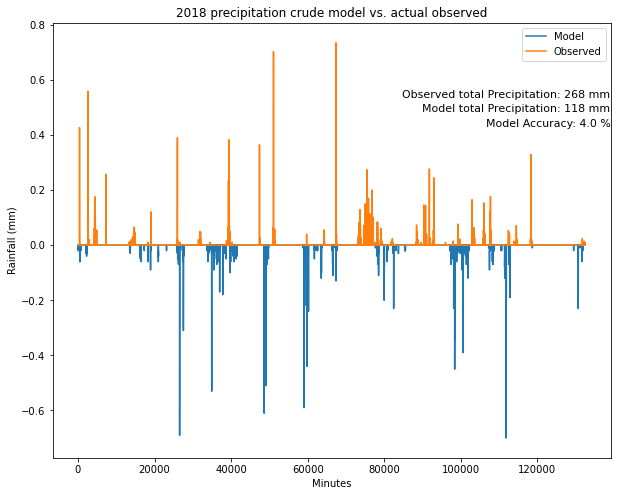

In [64]:
plt.figure(figsize = (10, 8))
plt.plot(-sample_output)
plt.plot(new_summer18)
plt.title('2018 precipitation crude model vs. actual observed')
plt.xlabel('Minutes')
plt.ylabel('Rainfall (mm)')
plt.legend(['Model', 'Observed'], loc = 'upper right')
plt.figtext(0.9, 0.75, 'Observed total Precipitation: ' + str(round(np.nansum(compare_data))) + ' mm', fontsize = 11, ha = 'right')
plt.figtext(0.9, 0.725, 'Model total Precipitation: ' + str(round(np.nansum(sample_output))) + ' mm', fontsize = 11, ha = 'right')
plt.figtext(0.9, 0.7, 'Model Accuracy: ' + str(round(Sum_accuracy, 1)) + ' %', fontsize = 11, ha = 'right')

In [50]:
Sum_average_precip = 0
Sum_avg_precip_accur = 0

for i in range(100):
    sample_output, compare_data = model_1(Summer18, 5000, 1)
    Sum_average_precip = Sum_average_precip + sum(sample_output)
    Su_precip18M, Su_nonprecip18M, Su_preciptotal18M, Su_totalprep18M = histplot.preciphist(sample_output, len(sample_output), 5000, 1, 1)
    pre_accuracy = mod_acc1(sample_output, new_summer18, int(sum(Su_precip18M)))
    Sum_avg_precip_accur = Sum_avg_precip_accur + pre_accuracy
Sum_average_precip = Sum_average_precip/100
Sum_avg_precip_accur = Sum_avg_precip_accur/100

print(Sum_average_precip)
print(Sum_avg_precip_accur)

121.68710000000155
2.635334885538556


In [67]:
precip18, nonprecip18, preciptotal18, totalprep18 = histplot.preciphist(Whole18, len(Whole18), 20000, 1, 1)

In [53]:
mod_precip18, mod_nonprecip18, mod_preciptotal18, mod_totalprep18 = histplot.preciphist(sample_2018, len(sample_output), 20000, 1, 1)

In [69]:
nonprecip18 = nonprecip18[nonprecip18>0]
precip18 = precip18[precip18>0]
#print(Su_precip18)
#print(Su_nonprecip18)


In [70]:
preciptotal18 = preciptotal18[preciptotal18 > 0]


In [71]:
inten18 = np.divide(preciptotal18, precip18)
print(len(inten18))

4118


In [72]:
print(nonprecip18.sum() + precip18.sum())
print(len(nonprecip18))
print(len(precip18))
print(len(compare_data))
print(len(sample_output))

525562.0
4119
4118
132477
132477


In [73]:
sample_2018, compare2018 = model_1(Whole18, 20000, 1)

In [74]:
hold = np.sum(nonprecip18) + np.sum(precip18)
new2018 = np.zeros(int(hold))
minute = 0;
pre_index = 0;
np_index = 0;
while(int(hold)-1 > minute):
    if (len(nonprecip18) > np_index):
        non = nonprecip18[np_index]
        for i in range(int(non)):
            new2018[minute] = 0
            minute += 1
    if (len(precip18)> pre_index):    
        rain = precip18[pre_index]
        for j in range(int(rain)):
            new2018[minute] = inten18[pre_index]
            minute += 1
    pre_index += 1 
    np_index +=1


In [77]:
pre_accuracy = mod_acc1(sample_2018, compare2018, hold)

Text(0.45, 0.8, 'Precipitation accuracy: 0.2 %')

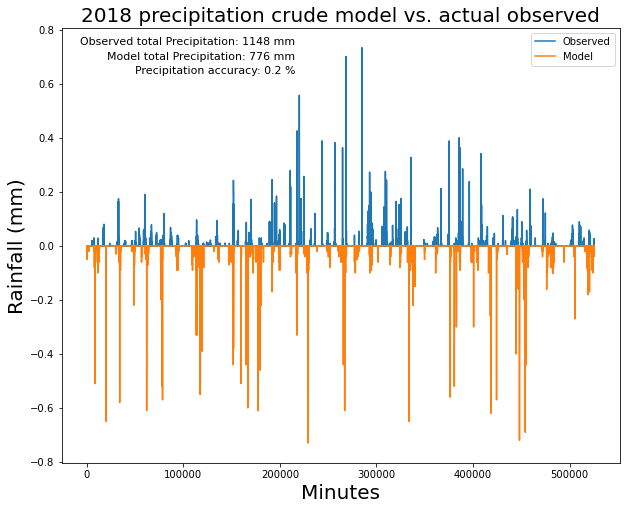

In [79]:
plt.figure(figsize = (10,8))
plt.plot(new2018)
plt.plot(-sample_2018)
plt.title('2018 precipitation crude model vs. actual observed', fontsize = 20)
plt.xlabel('Minutes', fontsize = 20)
plt.ylabel('Rainfall (mm)', fontsize = 20)
plt.legend(['Observed', 'Model'], loc = 'upper right')
plt.figtext(0.45, 0.85, 'Observed total Precipitation: ' + str(round(np.nansum(new2018))) + ' mm', fontsize = 11, ha = 'right')
plt.figtext(0.45, 0.825, 'Model total Precipitation: ' + str(round(np.nansum(sample_2018))) + ' mm', fontsize = 11, ha = 'right')
plt.figtext(0.45, 0.8, 'Precipitation accuracy: ' + str(round(pre_accuracy,1)) + ' %', fontsize = 11, ha = 'right')


In [56]:
pre_min = sum(precip18)
print(pre_min)
pre_model = sum(mod_precip18)
print(pre_model)

19708.0
15490.0


In [57]:
model_accuracy = 0
for i in range(len(new2018)):
    mod = sample_2018[i]
    obs = new2018[i]
    if (mod == 0 and obs == 0):
        model_accuracy += 1
    elif (mod > 0 and obs > 0):
        model_accuracy += 1
    else: 
        model_accuracy += 0
model_accuracy = model_accuracy/len(new2018)
print(mod_acc1(sample_2018, new2018, pre_model))
print(mod_acc2(sample_2018, new2018, pre_model))
pre_accuracy = mod_acc1(sample_2018, new2018, pre_model)

16.714009038089088
1.6655907036797934


In [39]:
print(model_accuracy)

0.9249108573298679


Text(0.9, 0.7, 'Model percent without precipitation: 97.3 %')

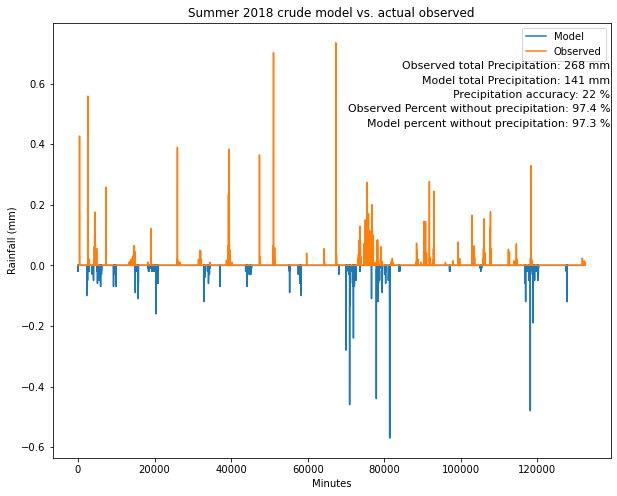

In [40]:
plt.figure(figsize = (10, 8))
plt.plot(-sample_output)
plt.plot(new_summer18)
plt.title('Summer 2018 crude model vs. actual observed')
plt.xlabel('Minutes')
plt.ylabel('Rainfall (mm)')
plt.legend(['Model', 'Observed'], loc = 'upper right')
plt.figtext(0.9, 0.8, 'Observed total Precipitation: ' + str(round(Su_totalprep18)) + ' mm', fontsize = 11, ha = 'right')
plt.figtext(0.9, 0.775, 'Model total Precipitation: ' + str(round(sum(sample_output))) + ' mm', fontsize = 11, ha = 'right')
plt.figtext(0.9, 0.75, 'Precipitation accuracy: ' + str(round(pre_accuracy)) + ' %', fontsize = 11, ha = 'right')
plt.figtext(0.9, 0.725, 'Observed Percent without precipitation: ' + str(round(len(new_summer18[new_summer18 == 0])/len(new_summer18)*100,1)) + ' %', fontsize = 11, ha = 'right')
plt.figtext(0.9, 0.7, 'Model percent without precipitation: ' + str(round(len(sample_output[sample_output == 0])/len(sample_output)*100,1)) + ' %', fontsize = 11, ha = 'right')

In [29]:
average_precip = 0
avg_precip_accur = 0
for i in range(100):
    sample_output, compare_data = model_1(Summer18, 5000, 1)
    average_precip = average_precip + sum(sample_output)
    pre_accuracy = mod_acc1(sample_output, new_summer18, pre_min)
    avg_precip_accur = avg_precip_accur + pre_accuracy
average_precip = average_precip/100
avg_precip_accur = avg_precip_accur/100

print(average_precip)
print(avg_precip_accur)

115.22910000000124
2.7184126057776483
